 ## Loading the Datasets

In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Main Dataset

# Conversation Data -- we will use this data in the "Conversation Data" section

df = pd.read_json(
    "chatbot-arena-conversations.jsonl.gz",
    compression="gzip",
    lines=True)
df.head(5)

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use..."


In [312]:
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [313]:
test_df = pd.read_json(
    "chatbot-arena-conversations.jsonl.gz",
    compression="gzip",
    lines=True)
test_df.head(5)

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use..."


In [314]:
#testing data frames 

test_topic_and_hardness = pd.read_json(
    "arena-test-set-topic-modeling.jsonl.gz",
    lines=True,
    compression="gzip"
)

test_prompts = np.load(
    "arena-test-set-prompts-embeddings.npy"
)

test_response_a_embeddings = np.load(
    "arena-test-set-model_a_response-embeddings.npy"
)

test_response_b_embeddings = np.load(
    "arena-test-set-model_b_response-embeddings.npy"
)

test_pr = pd.read_json(
    "arena-test-set-prompt-and-responses.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [315]:
test_pr.columns

Index(['question_id', 'prompt', 'model_a', 'model_b', 'model_a_response',
       'model_b_response'],
      dtype='object')

In [316]:
# Extracting the prompt
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt"].head(1)
df["prompt"].value_counts()

prompt
What is the meaning of life?                                                                                                                                                                                                                                                                                                                                                                                                                               33
Sally (a girl) has 3 brothers. Each brother has 2 sisters. How many sisters does sally have?                                                                                                                                                                                                                                                                                                                                                               26
She felt something and likes me but loves other man. She lied about it for a month, treated me like j

In [317]:
# Extracting the prompt
test_df["prompt"] = test_df["conversation_a"].str[0].str["content"]
test_df["prompt"].head(1)
test_df["prompt"].value_counts()

prompt
What is the meaning of life?                                                                                                                                                                                                                                                                                                                                                                                                                               33
Sally (a girl) has 3 brothers. Each brother has 2 sisters. How many sisters does sally have?                                                                                                                                                                                                                                                                                                                                                               26
She felt something and likes me but loves other man. She lied about it for a month, treated me like j

In [318]:
#add columns to separate responses from the conversation (we already did this for the prompt)
df["model_a_response"] = df["conversation_a"].str[1].str["content"]
df["model_b_response"] = df["conversation_b"].str[1].str["content"]
df["model_a_response"][2]

'Both Fuji and Nikon are popular camera brands that offer a wide range of cameras for different types of photography. It really depends on your specific needs and preferences as to which brand is "better" for you.\n\nFujifilm is known for its high image quality, especially in the areas of color accuracy and dynamic range. Many photographers also appreciate the company\'s focus on ergonomics and the overall user experience of its cameras. Additionally, Fujifilm has a loyal following among enthusiasts and professional photographers, thanks to its commitment to film photography and its high-end mirrorless cameras.\n\nNikon, on the other hand, is known for its advanced autofocus system and image stabilization technology, as well as its high-end cameras and lenses. Nikon also has a wide selection of cameras and lenses to choose from, including both DSLR and mirrorless options.\n\nUltimately, it\'s difficult to say which brand is "better" without knowing more about your specific needs and pr

In [319]:
#add columns to separate responses from the conversation (we already did this for the prompt)
test_df["model_a_response"] = test_df["conversation_a"].str[1].str["content"]
test_df["model_b_response"] = test_df["conversation_b"].str[1].str["content"]
test_df["model_a_response"][2]

'Both Fuji and Nikon are popular camera brands that offer a wide range of cameras for different types of photography. It really depends on your specific needs and preferences as to which brand is "better" for you.\n\nFujifilm is known for its high image quality, especially in the areas of color accuracy and dynamic range. Many photographers also appreciate the company\'s focus on ergonomics and the overall user experience of its cameras. Additionally, Fujifilm has a loyal following among enthusiasts and professional photographers, thanks to its commitment to film photography and its high-end mirrorless cameras.\n\nNikon, on the other hand, is known for its advanced autofocus system and image stabilization technology, as well as its high-end cameras and lenses. Nikon also has a wide selection of cameras and lenses to choose from, including both DSLR and mirrorless options.\n\nUltimately, it\'s difficult to say which brand is "better" without knowing more about your specific needs and pr

In [320]:
#create columns for prompt and response lengths
df["prompt_length"] = df["prompt"].str.len()
df["prompt_length"].describe() #use this if you want to know statistics about prompt and response lengths

df["response_a_length"] = df["model_a_response"].str.len()


df["response_b_length"] = df["model_b_response"].str.len()


In [321]:
test_df["prompt_length"] = test_df["prompt"].str.len()
test_df["prompt_length"].describe() #use this if you want to know statistics about prompt and response lengths

test_df["response_a_length"] = test_df["model_a_response"].str.len()


test_df["response_b_length"] = test_df["model_b_response"].str.len()

In [322]:
test_df.columns

Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'model_a_response',
       'model_b_response', 'prompt_length', 'response_a_length',
       'response_b_length'],
      dtype='object')

### Engineering feature of dot product similarity between embeddings

In [323]:
assert len(prompt_embeddings) == len(df), "Mismatch between prompt embeddings and DataFrame rows."
assert len(response_a_embeddings) == len(df), "Mismatch between response_a embeddings and DataFrame rows."
assert len(response_b_embeddings) == len(df), "Mismatch between response_b embeddings and DataFrame rows."

# Compute dot products and add them as new columns to the original DataFrame
df['similarity_prompt_response_a'] = [
    np.dot(prompt, response_a)
    for prompt, response_a in zip(prompt_embeddings, response_a_embeddings)
]

df['similarity_prompt_response_b'] = [
    np.dot(prompt, response_b)
    for prompt, response_b in zip(prompt_embeddings, response_b_embeddings)
]


In [324]:
assert len(prompt_embeddings) == len(test_df), "Mismatch between prompt embeddings and DataFrame rows."
assert len(response_a_embeddings) == len(test_df), "Mismatch between response_a embeddings and DataFrame rows."
assert len(response_b_embeddings) == len(test_df), "Mismatch between response_b embeddings and DataFrame rows."


#### Converting the score_value_"n" columns, in topic_and_hardness dataframe, to numeric values and stored in the column "hardness_score"

In [325]:
test_topic_and_hardness.columns

Index(['question_id', 'prompt', 'topic_modeling_1', 'topic_modeling_2',
       'topic_modeling_3'],
      dtype='object')

In [326]:
#convert hardness scores from list to numeric
topic_and_hardness['score_value_1'] = pd.to_numeric(topic_and_hardness['score_value_1'], errors='coerce')
topic_and_hardness['score_value_2'] = pd.to_numeric(topic_and_hardness['score_value_2'], errors='coerce')
topic_and_hardness['score_value_3'] = pd.to_numeric(topic_and_hardness['score_value_3'], errors='coerce')

In [327]:
topic_and_hardness.drop_duplicates(subset='question_id', inplace=True)

In [328]:
#this will merge the mean value of the hardness scores and the topic_modeling 3 with the main data set
topic_and_hardness['hardness_score'] = topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].mean(axis=1)
merged_df = df.merge(topic_and_hardness[['question_id', 'hardness_score', 'topic_modeling_3']], on='question_id', how='left')

In [329]:
test_merged_df = test_df.merge(test_topic_and_hardness[['question_id','topic_modeling_3']], on='question_id', how='left')

In [330]:
test_merged_df = test_merged_df.fillna(0)

#### Removing question ids that produce null values and storing the final dataset into filtered_df

In [331]:
# To Do: fetch code where we identified these question IDs @caroline
# This will remove question ids that produced null values for topic_and_hardness
filtered_df = merged_df[
    ~merged_df['question_id'].isin([
        'e6d45ead33114cca8ee3cfa028517eff',
        'addaa796ee094f029f8014ea1468df8a',
        'd37eb99864fa41ecab49026abdddb53e',
        '6da02001e74041d0947982fb4d05db9e',
        'd93e36df73e84aa2ade15d4a038c098f',
        '50b63f92bc5948218e1555d1eae17797',
        '8277b16d9a0845d694a33c04f446926c',
        'd56d698d4c1c495682a366f2a78fcb77',
        '86c7abedb5f84b7ea752cc98d324d387',
        '974569d7b9c74ca591f1922bf3722266',
        'ba3cfbae941946c6a41ea725b46f3aa7',
        '283be8724d674cb6a74da59d0c12ea16',
        'fbd400babd914eb1ad6202b4400d6beb',
        '087b90bf76ed4c409b7c7bd5d6b0d6c5',
        'f9ad250d0194489b8b9f12d31386aab1',
        '7e371a23981847c7b19bc61195f11eda',
        'f55b273603754c0d92f5139351ca0d02',
        '255e1466eaf14cc2ba93040776c0c440',
        '6979b646271e46f4a329a5e6acaeed38',
        'ed7fa335d5524295b1dd79452778d26c',
        'f794c699e4964b11a1373976be5b0944',
        'c92bcab701cc46649368fc121b84ccc1',
        'a632607132cf4908883fd262102714c9',
        'a0857d64b4954ea6bd75c2406c3dd32c',
        'e4a1fc8a9462475d95022914cb9f5b03',
        'c7aa752f61dc46d093dc86713686f6f3'
    ])
]


In [332]:
testing = test_df[
    ~test_df['question_id'].isin([
        'e6d45ead33114cca8ee3cfa028517eff',
        'addaa796ee094f029f8014ea1468df8a',
        'd37eb99864fa41ecab49026abdddb53e',
        '6da02001e74041d0947982fb4d05db9e',
        'd93e36df73e84aa2ade15d4a038c098f',
        '50b63f92bc5948218e1555d1eae17797',
        '8277b16d9a0845d694a33c04f446926c',
        'd56d698d4c1c495682a366f2a78fcb77',
        '86c7abedb5f84b7ea752cc98d324d387',
        '974569d7b9c74ca591f1922bf3722266',
        'ba3cfbae941946c6a41ea725b46f3aa7',
        '283be8724d674cb6a74da59d0c12ea16',
        'fbd400babd914eb1ad6202b4400d6beb',
        '087b90bf76ed4c409b7c7bd5d6b0d6c5',
        'f9ad250d0194489b8b9f12d31386aab1',
        '7e371a23981847c7b19bc61195f11eda',
        'f55b273603754c0d92f5139351ca0d02',
        '255e1466eaf14cc2ba93040776c0c440',
        '6979b646271e46f4a329a5e6acaeed38',
        'ed7fa335d5524295b1dd79452778d26c',
        'f794c699e4964b11a1373976be5b0944',
        'c92bcab701cc46649368fc121b84ccc1',
        'a632607132cf4908883fd262102714c9',
        'a0857d64b4954ea6bd75c2406c3dd32c',
        'e4a1fc8a9462475d95022914cb9f5b03',
        'c7aa752f61dc46d093dc86713686f6f3'
    ])
]

In [333]:
len(testing['question_id'])

25256

#### Calculating the ELO ratings per model:

In [334]:
# Initialize ratings dictionary with a default rating (e.g., 1000 for each model)
elo_ratings = {model: 1000 for model in pd.concat([filtered_df["model_a"], filtered_df["model_b"]]).unique()}

def update_elo(winner, loser, k=32):
    """Adjust the ELO rating based on the winner and loser models."""
    winner_rating = elo_ratings[winner]
    loser_rating = elo_ratings[loser]

    # expected scores
    expected_winner = 1 / (1 + 10 ** ((loser_rating - winner_rating) / 400))
    expected_loser = 1 - expected_winner

    # update ratings
    elo_ratings[winner] += k * (1 - expected_winner)
    elo_ratings[loser] += k * (0 - expected_loser)

# Loop over each row to adjust ELO ratings
for i, row in filtered_df.iterrows():
    if row["winner"] == "model_a":
        update_elo(row["model_a"], row["model_b"])
    elif row["winner"] == "model_b":
        update_elo(row["model_b"], row["model_a"])

# convert ELO ratings to a sorted DataFrame
elo_df = pd.DataFrame(list(elo_ratings.items()), columns=["model", "ELO_rating"]).sort_values(by="ELO_rating", ascending=False)
print("ELO ratings per model:")
print(elo_df)




ELO ratings per model:
                      model   ELO_rating
15        claude-instant-v1  1292.688016
10                    gpt-4  1250.726993
11                claude-v1  1234.758964
19              guanaco-33b  1124.567221
9             gpt-3.5-turbo  1110.799361
3                vicuna-13b  1109.473792
14                   palm-2  1074.086047
2                 koala-13b  1069.641717
16                vicuna-7b  1050.621375
17             wizardlm-13b   997.391029
13              mpt-7b-chat   969.416715
12         RWKV-4-Raven-14B   937.085978
5                alpaca-13b   928.131634
18       gpt4all-13b-snoozy   926.279119
0                chatglm-6b   889.066656
1          oasst-pythia-12b   884.891087
4   stablelm-tuned-alpha-7b   839.718473
8            fastchat-t5-3b   827.172397
6                 llama-13b   773.750292
7              dolly-v2-12b   709.733134


In [335]:
# testing

elo_ratings = {model: 1000 for model in pd.concat([test_merged_df["model_a"], test_merged_df["model_b"]]).unique()}

# Loop over each row to adjust ELO ratings
for i, row in test_merged_df.iterrows():
    if row["winner"] == "model_a":
        update_elo(row["model_a"], row["model_b"])
    elif row["winner"] == "model_b":
        update_elo(row["model_b"], row["model_a"])


### Create column where the ELO ratings are compared, model a minus model b, to give a measure of which model is stronger so that we can include the prompt features as well in our tasks

## Topics feature

In [336]:
# Define regex patterns and their corresponding feature names
core_topics = {
    r'math': 'topic_math',
    r'fact\w*': 'topic_fact',
    r'creativ\w*': 'topic_creative',
    r'problem[ -]?solving': 'topic_problem_solving'
}

# Apply one-hot encoding for the defined core topics
for pattern, feature_name in core_topics.items():
    filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int)

/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/3353661848.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int)
/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/3353661848.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int

In [337]:
# Define regex patterns and their corresponding feature names
core_topics = {
    r'math': 'topic_math',
    r'creativ\w*': 'topic_creative',
}

# Apply one-hot encoding for the defined core topics
for pattern, feature_name in core_topics.items():
    test_merged_df[feature_name] = test_merged_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int)

from textblob import TextBlob

# Ensure required columns exist in the test set
test_df['prompt_length'] = test_df['prompt'].apply(len)

# Length interaction
test_df['length_interaction'] = test_df['prompt_length']  # Placeholder until response lengths are defined
test_df['response_a_length'] = test_df['model_a_response'].apply(len)
test_df['response_b_length'] = test_df['model_b_response'].apply(len)
test_df['length_interaction'] = test_df['response_a_length'] * test_df['response_b_length']

# Sentiment analysis for responses and prompts
test_df['response_a_polarity'] = test_df['model_a_response'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)
test_df['response_b_polarity'] = test_df['model_b_response'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)
test_df['response_a_length_polarity'] = (
    test_df['response_a_length'] * test_df['response_a_polarity']
)
test_df['response_b_length_polarity'] = (
    test_df['response_b_length'] * test_df['response_b_polarity']
)

# POS tagging for noun and verb counts
test_df['prompt_noun_count'] = test_df['prompt'].apply(
    lambda x: len([word for word, pos in TextBlob(x).tags if pos.startswith('NN')])
)
test_df['prompt_verb_count'] = test_df['prompt'].apply(
    lambda x: len([word for word, pos in TextBlob(x).tags if pos.startswith('VB')])
)
test_df['model_a_response_noun_count'] = test_df['model_a_response'].apply(
    lambda x: len([word for word, pos in TextBlob(x).tags if pos.startswith('NN')])
)
test_df['model_a_response_verb_count'] = test_df['model_a_response'].apply(
    lambda x: len([word for word, pos in TextBlob(x).tags if pos.startswith('VB')])
)
test_df['model_b_response_noun_count'] = test_df['model_b_response'].apply(
    lambda x: len([word for word, pos in TextBlob(x).tags if pos.startswith('NN')])
)
test_df['model_b_response_verb_count'] = test_df['model_b_response'].apply(
    lambda x: len([word for word, pos in TextBlob(x).tags if pos.startswith('VB')])
)


In [338]:
test_merged_df.head()

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,model_a_response,model_b_response,prompt_length,response_a_length,response_b_length,topic_modeling_3,topic_math,topic_creative
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,47,892,1905,0,0,0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,49,660,514,0,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",Both Fuji and Nikon are popular camera brands ...,This is a subjective question and the answer d...,32,1114,1566,0,0,0
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,35,1575,1624,0,0,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",17,267,27,0,0,0


## Auxiliary verbs feature

In [339]:
import re

# Define the modal verbs
modal_verbs = ['can', 'could', 'may', 'might', 'shall', 'should', 'will', 'would', 'must', 'have to']

# Create a regex pattern (case-insensitive)
modal_regex = '|'.join([re.escape(verb) for verb in modal_verbs])

# Function to one-hot encode the presence of modal verbs
def one_hot_modal_features(df, column_name, modal_regex):
    for verb in modal_verbs:
        pattern = rf'\b{re.escape(verb)}\b'
        df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int)
    return df

# Apply the function to both model_a_response and model_b_response
filtered_df = one_hot_modal_features(filtered_df, 'model_a_response', modal_regex)
filtered_df = one_hot_modal_features(filtered_df, 'model_b_response', modal_regex)


/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/147118259.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int)
/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/147118259.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int

# HERE

In [340]:
#Imports
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_squared_error, mean_absolute_error, explained_variance_score, r2_score)


In [341]:
def extract_textblob_features(df, text_column):
    """ 
    To extract sentiment and linguistic features utilizing TextBlob

    Parameters:
        df: Input Dataframe
        text_column: Name of column with text data

    Returns:
        df: Updated Dataframe with the extracted features as new columns
    """
    # initialize lists to store the extracted features
    polarity = [] # sentiment polarity scores
    noun_count = [] # number of nouns 
    verb_count = [] # number of verbs
    adj_count = [] # number of adjectives

    # loop through each row in column 
    for text in df[text_column]:
        # Create a TextBlob object to analyze the text
        blob = TextBlob(text)
        polarity.append(blob.sentiment.polarity)
        # count nouns
        noun_count.append(len([word for word, pos in blob.tags if pos.startswith('NN')]))
        # count verbs 
        verb_count.append(len([word for word, pos in blob.tags if pos.startswith('VB')]))

    # Add extracted features to the DataFrame as new columns 
    df[f"{text_column}_polarity"] = polarity
    df[f"{text_column}_noun_count"] = noun_count
    df[f"{text_column}_verb_count"] = verb_count

    return df

# Use textblob featuures on prompts and responses
filtered_df = extract_textblob_features(filtered_df, 'prompt')
filtered_df = extract_textblob_features(filtered_df, 'model_a_response')
filtered_df = extract_textblob_features(filtered_df, 'model_b_response')
test_merged_df = extract_textblob_features(test_merged_df, 'prompt')
test_merged_df = extract_textblob_features(test_merged_df, 'model_a_response')
test_merged_df = extract_textblob_features(test_merged_df, 'model_b_response')

/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/1150135445.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{text_column}_polarity"] = polarity
/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/1150135445.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{text_column}_noun_count"] = noun_count
/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/1150135445.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [342]:
## Feature engineering: interaction terms

# Will the combined length of both of the models' responses have an impact on hardness score?
filtered_df.loc[:, 'length_interaction'] = (filtered_df['response_a_length'] * filtered_df['response_b_length'])

# Interaction between response lengths and sentiment polarity
# Thought process: a long positive response may be deemed a low hardness score and a long negative response may be deemed a high hardness score
filtered_df['response_a_length_polarity'] = (filtered_df['response_a_length'] * filtered_df['model_a_response_polarity'])
filtered_df['response_b_length_polarity'] = (filtered_df['response_b_length'] * filtered_df['model_b_response_polarity'])

# Will this interaction between ELO ratings provide insight into whether difference in the skill level between models contributes to hardness scores?
filtered_df['elo_modela_minus_modelb'] = filtered_df.apply(lambda row: elo_ratings[row['model_a']] - elo_ratings[row['model_b']], axis=1)

/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/4015806261.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'length_interaction'] = (filtered_df['response_a_length'] * filtered_df['response_b_length'])
/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/4015806261.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['response_a_length_polarity'] = (filtered_df['response_a_length'] * filtered_df['model_a_response_polarity'])
/var/folders/yl/05hmr

In [343]:
# testing
# Will the combined length of both of the models' responses have an impact on hardness score?
test_merged_df.loc[:, 'length_interaction'] = (test_merged_df['response_a_length'] * test_merged_df['response_b_length'])

# Interaction between response lengths and sentiment polarity
# Thought process: a long positive response may be deemed a low hardness score and a long negative response may be deemed a high hardness score
test_merged_df['response_a_length_polarity'] = (test_merged_df['response_a_length'] * test_merged_df['model_a_response_polarity'])
test_merged_df['response_b_length_polarity'] = (test_merged_df['response_b_length'] * test_merged_df['model_b_response_polarity'])

# Will this interaction between ELO ratings provide insight into whether difference in the skill level between models contributes to hardness scores?
test_merged_df['elo_modela_minus_modelb'] = test_merged_df.apply(lambda row: elo_ratings[row['model_a']] - elo_ratings[row['model_b']], axis=1)

<Axes: >

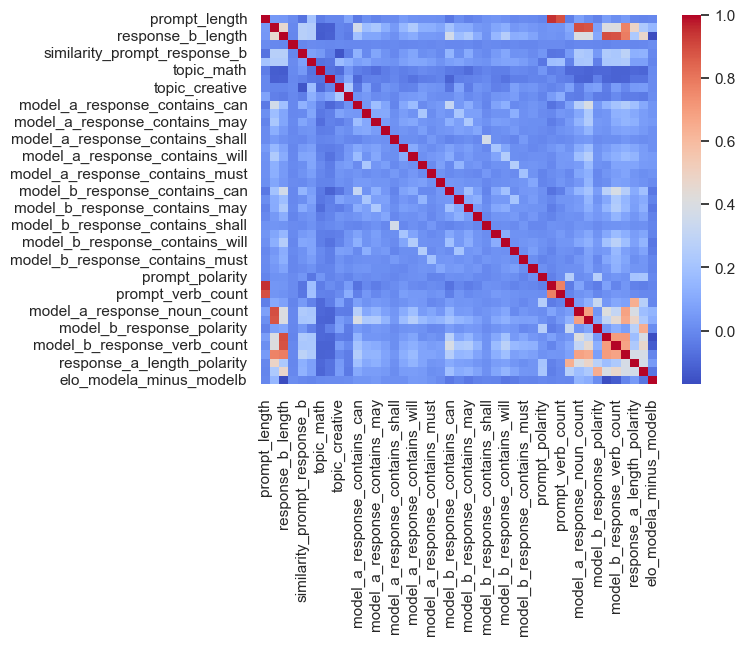

In [344]:
# Analyzing the numeric columns from the data for correlation analysis for feature interaction analysis
numeric_df = filtered_df.select_dtypes(include=[np.number])

# correlation matrix for the numeric data
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')

In [345]:
# The selected features for training the model
selected_features = ['prompt_length',
    'length_interaction', 'elo_modela_minus_modelb',
    'prompt_noun_count', 'prompt_verb_count', 
    'response_a_length_polarity', 'response_b_length_polarity',
    'model_a_response_noun_count', 'model_a_response_verb_count',
    'model_b_response_noun_count', 'model_b_response_verb_count', 'topic_math', 'topic_creative']

In [346]:
testing_features = test_merged_df[['prompt_length',
    'length_interaction', 'elo_modela_minus_modelb',
    'prompt_noun_count', 'prompt_verb_count', 
    'response_a_length_polarity', 'response_b_length_polarity',
    'model_a_response_noun_count', 'model_a_response_verb_count',
    'model_b_response_noun_count', 'model_b_response_verb_count', 'topic_math', 'topic_creative']]

In [347]:
testing_features = testing_features.loc[:, ~testing_features.columns.duplicated()]


In [348]:
# ensure y is cleaned first
y = filtered_df['hardness_score']
y = y.dropna()  # drop NaN values

# Ensure X aligns with cleaned y
X = filtered_df[selected_features].loc[y.index]

# drop missing or infinite values in X
X = X.dropna()

# aligns X and y indices after filtering
X, y = X.align(y, axis=0)


In [349]:

print(X.shape)
print(testing_features.shape)

(25223, 13)
(25283, 13)


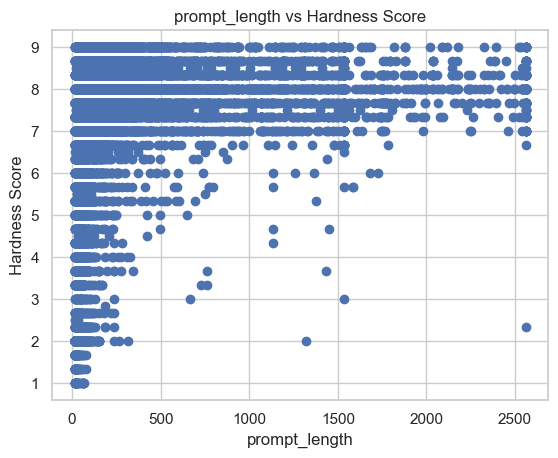

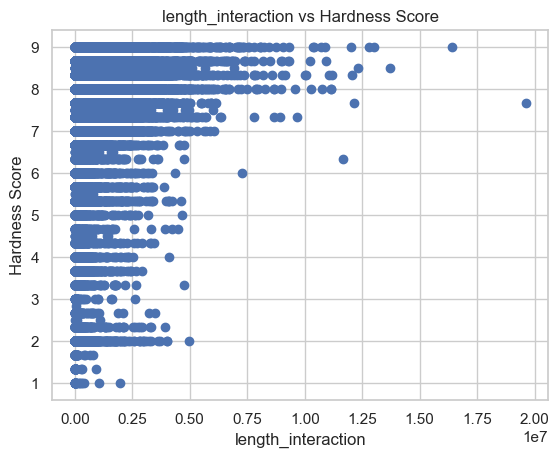

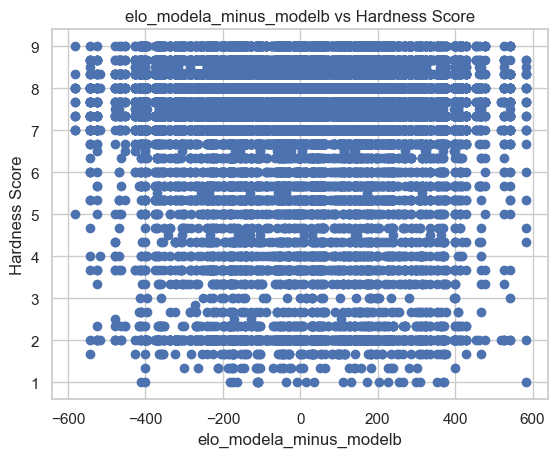

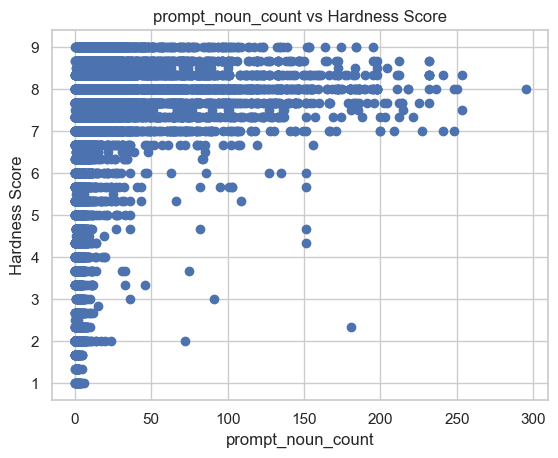

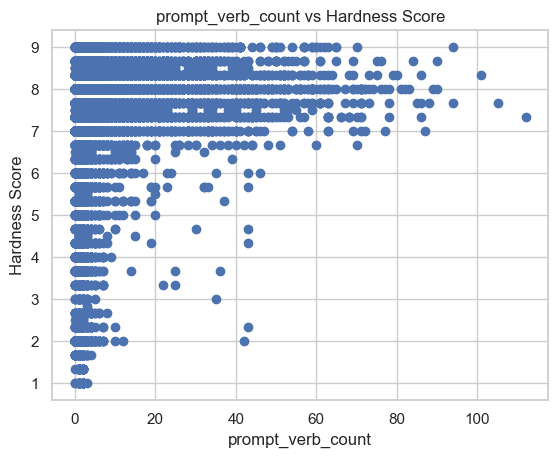

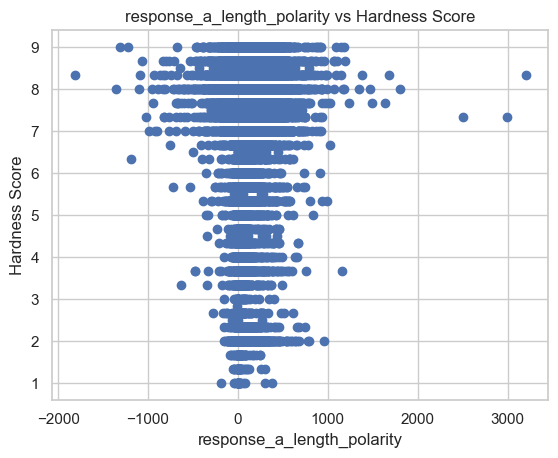

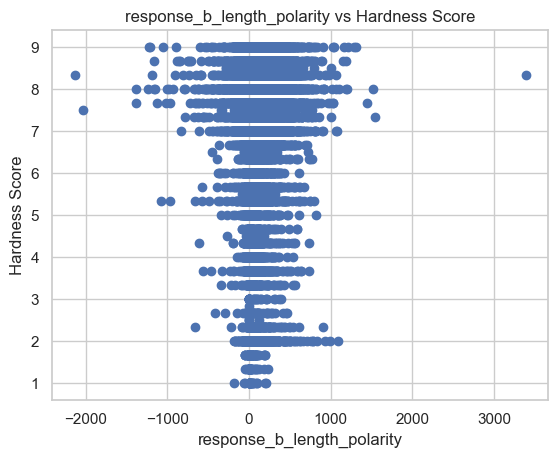

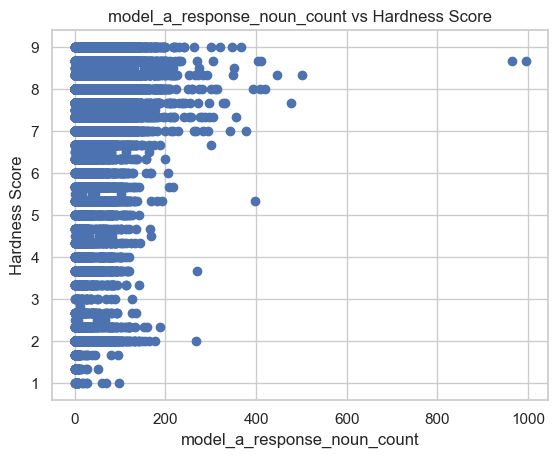

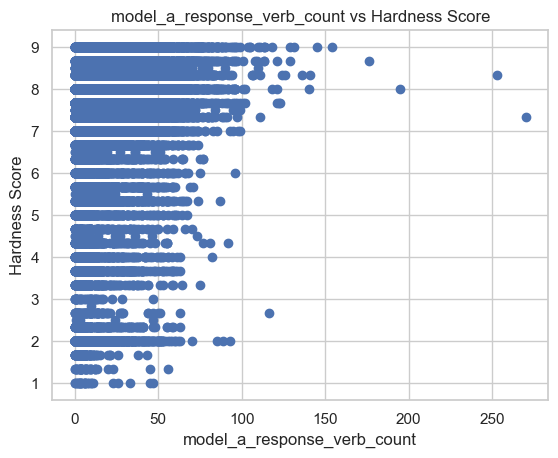

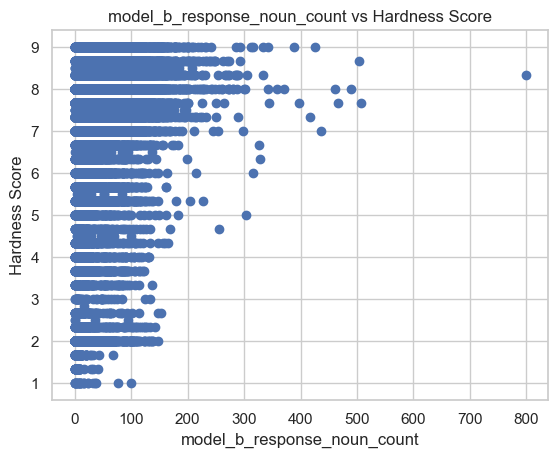

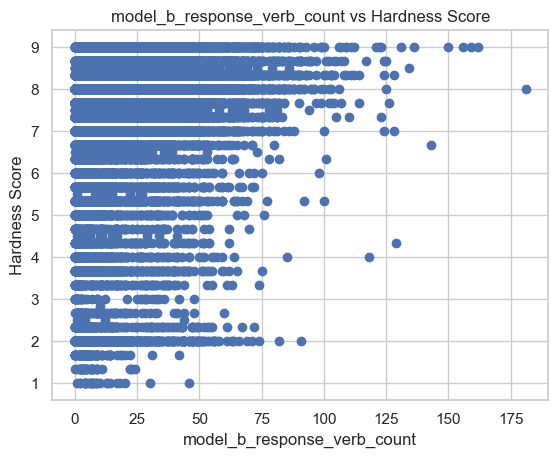

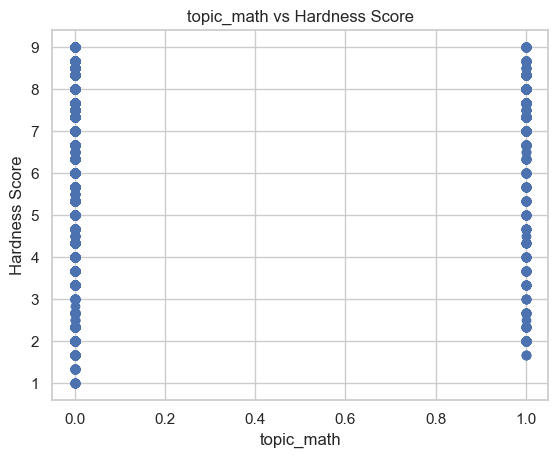

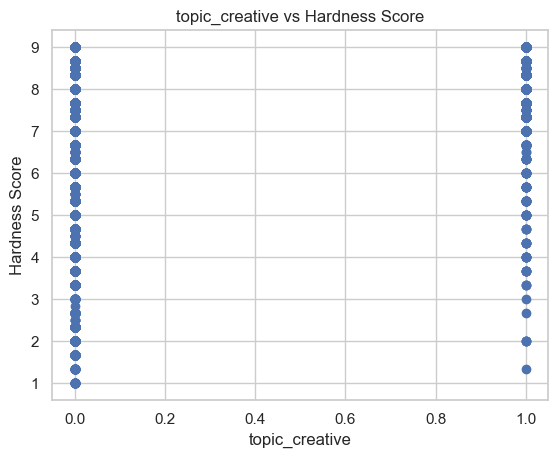

In [350]:
# iterate over each column in the feature set to visualize its the relationship with hardness score
for column in X.columns:
    plt.scatter(X[column], y)
    plt.title(f"{column} vs Hardness Score")
    plt.xlabel(column)
    plt.ylabel("Hardness Score")
    plt.show()


In [351]:
# Function for oversampling low-range data
def oversample_low_range(X, y, low_threshold=3):
    """
    Oversample the low-range target values to address class imbalance
    
    Parameters:
    - X: Features (DataFrame)
    - y: Target variable (Series)
    - low_threshold: Threshold to define the low range
    
    Returns:
    - X_combined: Oversampled features
    - y_combined: Oversampled target variable
    """
    # alignment
    X, y = X.align(y, axis=0)

    # identify low range
    low_range = y <= low_threshold
    X_low, y_low = X[low_range], y[low_range]

    # If no low-range samples exist, return original data
    if X_low.empty or y_low.empty:
        print("Warning: No low-range data available for oversampling.")
        return X, y

    # Oversample low-range data
    X_oversampled, y_oversampled = resample(
        X_low, y_low,
        replace=True,  # Oversampling with replacement
        n_samples=X.shape[0] // 3,  # Target size of oversampling
        random_state=42
    )

    # Combine oversampled data with the original dataset
    X_combined = pd.concat([X, X_oversampled])
    y_combined = pd.concat([y, y_oversampled])

    return X_combined, y_combined

In [352]:
def calculate_performance_metrics(y_true, y_pred, y_train=None, y_train_pred=None, y_val=None, y_val_pred=None):
    """
    Calculates various performance metrics for training, testing, and validation sets.
    
    Parameters:
    - y_true: True values for the test set.
    - y_pred: Predicted values for the test set.
    - y_train: True values for the training set (optional).
    - y_train_pred: Predicted values for the training set (optional).
    - y_val: True values for the validation set (optional).
    - y_val_pred: Predicted values for the validation set (optional).
    
    Returns:
    - metrics: Dictionary containing performance metrics.
    """
    metrics = {
        "Test RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "Test MSE": mean_squared_error(y_true, y_pred),
        "Test MAE": mean_absolute_error(y_true, y_pred),
        "Test R² Score": r2_score(y_true, y_pred),
        "Test Explained Variance": explained_variance_score(y_true, y_pred),
        "Test Residual Std Dev": np.std(y_true - y_pred),
    }
    
    if y_train is not None and y_train_pred is not None:
        metrics.update({
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
            "Train MSE": mean_squared_error(y_train, y_train_pred),
            "Train MAE": mean_absolute_error(y_train, y_train_pred),
            "Train R² Score": r2_score(y_train, y_train_pred),
            "Train Explained Variance": explained_variance_score(y_train, y_train_pred),
        })
    
    if y_val is not None and y_val_pred is not None:
        metrics.update({
            "Validation RMSE": np.sqrt(mean_squared_error(y_val, y_val_pred)),
            "Validation MSE": mean_squared_error(y_val, y_val_pred),
            "Validation MAE": mean_absolute_error(y_val, y_val_pred),
            "Validation R² Score": r2_score(y_val, y_val_pred),
            "Validation Explained Variance": explained_variance_score(y_val, y_val_pred),
        })
    
    return metrics

# Function to display performance metrics
def display_performance_metrics(metrics):
    """
    Display performance metrics in a readable format.
    
    Parameters:
    - metrics: Dictionary of performance metrics to display.
    """
    print("\nPerformance Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.2f}")


In [353]:
 #function to calculate range-specific RMSE
def calculate_range_rmse(y_true, y_pred, low_threshold=3, mid_threshold=6):
    y_pred_rounded = np.round(y_pred)
    rmse_low = np.sqrt(mean_squared_error(y_true[y_true <= low_threshold], y_pred_rounded[y_true <= low_threshold])) if (y_true <= low_threshold).sum() > 0 else np.nan
    rmse_mid = np.sqrt(mean_squared_error(y_true[(y_true > low_threshold) & (y_true <= mid_threshold)], y_pred_rounded[(y_true > low_threshold) & (y_true <= mid_threshold)])) if ((y_true > low_threshold) & (y_true <= mid_threshold)).sum() > 0 else np.nan
    rmse_high = np.sqrt(mean_squared_error(y_true[y_true > mid_threshold], y_pred_rounded[y_true > mid_threshold])) if (y_true > mid_threshold).sum() > 0 else np.nan
    return rmse_low, rmse_mid, rmse_high

# function to display range-specific RMSE
def display_range_rmse(rmse_low, rmse_mid, rmse_high):
    print("\nRange-Specific RMSE:")
    print(f"Low Range (<=3): {rmse_low:.2f}" if not np.isnan(rmse_low) else "Low Range (<=3): N/A")
    print(f"Mid Range (3-6): {rmse_mid:.2f}" if not np.isnan(rmse_mid) else "Mid Range (3-6): N/A")
    print(f"High Range (>6): {rmse_high:.2f}" if not np.isnan(rmse_high) else "High Range (>6): N/A")


In [354]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with missing target values
filtered_df = filtered_df.dropna(subset=['hardness_score'])

# Extract features and target variable
X = filtered_df[selected_features]
y = filtered_df['hardness_score']

# Oversample the low range 0-3
X_oversampled, y_oversampled = oversample_low_range(X, y)

# K-Fold Cross-Validation and Random Forest Regressor
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Storing all the metrics
rmse_scores_low, rmse_scores_mid, rmse_scores_high = [], [], []
training_scores, validation_scores = [], []
training_mse, validation_mse = [], []
training_mae, validation_mae = [], []
y_true_all, y_pred_all = [], []

# K-Fold Cross-Validation loop
for fold, (train_idx, test_idx) in enumerate(kf.split(X_oversampled), 1):
    print(f"Processing Fold {fold}...")
    
    X_train, X_test = X_oversampled.iloc[train_idx], X_oversampled.iloc[test_idx]
    y_train, y_test = y_oversampled.iloc[train_idx], y_oversampled.iloc[test_idx]

    # Train model
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    y_pred_test_rounded = np.round(y_pred_test)

    # True and predicted values for plotting
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred_test_rounded)

    # Training and validation R^2 scores calculations
    training_scores.append(rf_model.score(X_train, y_train))
    validation_scores.append(rf_model.score(X_test, y_test))

    # Training and validation MSE/MAE
    training_mse.append(mean_squared_error(y_train, y_pred_train))
    validation_mse.append(mean_squared_error(y_test, y_pred_test))
    training_mae.append(mean_absolute_error(y_train, y_pred_train))
    validation_mae.append(mean_absolute_error(y_test, y_pred_test))

    # Calculate RMSE for each range
    rmse_low, rmse_mid, rmse_high = calculate_range_rmse(y_test, y_pred_test)
    if not np.isnan(rmse_low): rmse_scores_low.append(rmse_low)
    if not np.isnan(rmse_mid): rmse_scores_mid.append(rmse_mid)
    if not np.isnan(rmse_high): rmse_scores_high.append(rmse_high)

# Calculate metrics
average_metrics = calculate_performance_metrics(np.array(y_true_all), np.array(y_pred_all))
rmse_low_avg = np.mean(rmse_scores_low)
rmse_mid_avg = np.mean(rmse_scores_mid)
rmse_high_avg = np.mean(rmse_scores_high)

# Display the metrics
display_performance_metrics(average_metrics)
display_range_rmse(rmse_low_avg, rmse_mid_avg, rmse_high_avg)

# Display training and validation metrics
print("\nTraining and Validation Metrics (Averages Across Folds):")
print(f"Training R²: {np.mean(training_scores):.2f}")
print(f"Validation R²: {np.mean(validation_scores):.2f}")
print(f"Training MSE: {np.mean(training_mse):.2f}")
print(f"Validation MSE: {np.mean(validation_mse):.2f}")
print(f"Training MAE: {np.mean(training_mae):.2f}")
print(f"Validation MAE: {np.mean(validation_mae):.2f}")

Processing Fold 1...
Processing Fold 2...
Processing Fold 3...
Processing Fold 4...
Processing Fold 5...

Performance Metrics:
Test RMSE: 1.06
Test MSE: 1.12
Test MAE: 0.66
Test R² Score: 0.84
Test Explained Variance: 0.85
Test Residual Std Dev: 1.03

Range-Specific RMSE:
Low Range (<=3): 0.40
Mid Range (3-6): 1.74
High Range (>6): 1.15

Training and Validation Metrics (Averages Across Folds):
Training R²: 0.97
Validation R²: 0.85
Training MSE: 0.20
Validation MSE: 1.05
Training MAE: 0.30
Validation MAE: 0.65


In [355]:
test_merged_df.columns

Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'model_a_response',
       'model_b_response', 'prompt_length', 'response_a_length',
       'response_b_length', 'topic_modeling_3', 'topic_math', 'topic_creative',
       'prompt_polarity', 'prompt_noun_count', 'prompt_verb_count',
       'model_a_response_polarity', 'model_a_response_noun_count',
       'model_a_response_verb_count', 'model_b_response_polarity',
       'model_b_response_noun_count', 'model_b_response_verb_count',
       'length_interaction', 'response_a_length_polarity',
       'response_b_length_polarity', 'elo_modela_minus_modelb'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with missing target values
filtered_df = filtered_df.dropna(subset=['hardness_score'])


# Extract features and target variable
X_t = testing_features
y_t = filtered_df['hardness_score']
y_t = y_t.dropna()

# aligns X and y indices after filtering
X_t, y_t = X_t.align(y_t, axis=0)

# Oversample the low range 0-3
X_oversampled_t, y_oversampled_t = oversample_low_range(X_t, y_t)

# K-Fold Cross-Validation and Random Forest Regressor
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Storing all the metrics
rmse_scores_low_t, rmse_scores_mid_t, rmse_scores_high_t = [], [], []
training_scores_t, validation_scores_t = [], []
training_mse_t, validation_mse_t = [], []
training_mae_t, validation_mae_t = [], []
y_true_all_t, y_pred_all_t = [], []

# K-Fold Cross-Validation loop
for fold, (train_idx, test_idx) in enumerate(kf.split(X_oversampled_t), 1):
    print(f"Processing Fold {fold}...")
    
    X_train_t, X_test_t = X_oversampled_t.iloc[train_idx], X_oversampled_t.iloc[test_idx]
    y_train_t, y_test_t = y_oversampled_t.iloc[train_idx], y_oversampled_t.iloc[test_idx]

    non_nan_indices = ~y_train_t.isnull()
    X_train_t = X_train_t[non_nan_indices]
    y_train_t = y_train_t[non_nan_indices]
    
    non_nan_test = ~y_test_t.isnull()
    X_test_t = X_test_t[non_nan_test]
    y_test_t = y_test_t[non_nan_test]
    # Train model
    rf_model.fit(X_train_t, y_train_t)

    # Predictions
    y_pred_train_t = rf_model.predict(X_train_t)
    y_pred_test_t = rf_model.predict(X_test_t)
    y_pred_test_rounded_t = np.round(y_pred_test_t)

    # True and predicted values for plotting
    y_true_all_t.extend(y_test_t)
    y_pred_all_t.extend(y_pred_test_rounded_t)

    # Training and validation R^2 scores calculations
    training_scores_t.append(rf_model.score(X_train_t, y_train_t))
    validation_scores_t.append(rf_model.score(X_test_t, y_test_t))

    # Training and validation MSE/MAE
    training_mse_t.append(mean_squared_error(y_train_t, y_pred_train_t))
    validation_mse_t.append(mean_squared_error(y_test_t, y_pred_test_t))
    training_mae_t.append(mean_absolute_error(y_train_t, y_pred_train_t))
    validation_mae_t.append(mean_absolute_error(y_test_t, y_pred_test_t))

    # Calculate RMSE for each range
    rmse_low_t, rmse_mid_t, rmse_high_t = calculate_range_rmse(y_test_t, y_pred_test_t)
    if not np.isnan(rmse_low_t): rmse_scores_low_t.append(rmse_low_t)
    if not np.isnan(rmse_mid_t): rmse_scores_mid_t.append(rmse_mid_t)
    if not np.isnan(rmse_high_t): rmse_scores_high_t.append(rmse_high_t)

# Calculate metrics
average_metrics_t = calculate_performance_metrics(np.array(y_true_all), np.array(y_pred_all))
rmse_low_avg_t = np.mean(rmse_scores_low_t)
rmse_mid_avg_t = np.mean(rmse_scores_mid_t)
rmse_high_avg_t = np.mean(rmse_scores_high_t)

# Display the metrics
display_performance_metrics(average_metrics_t)
display_range_rmse(rmse_low_avg_t, rmse_mid_avg_t, rmse_high_avg_t)

# Display training and validation metrics
print("\nTraining and Validation Metrics (Averages Across Folds):")
print(f"Training R² on testing data: {np.mean(training_scores_t):.2f}")
print(f"Validation R² on testing data: {np.mean(validation_scores_t):.2f}")
print(f"Training MSE on testing data: {np.mean(training_mse_t):.2f}")
print(f"Validation MSE on testing data: {np.mean(validation_mse_t):.2f}")
print(f"Training MAE on testing data: {np.mean(training_mae_t):.2f}")
print(f"Validation MAE on testing data: {np.mean(validation_mae_t):.2f}")

Processing Fold 1...
Processing Fold 2...
Processing Fold 3...
Processing Fold 4...


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ensure there are no NaN values in the target column before proceeding
filtered_df = filtered_df.dropna(subset=['hardness_score'])

# Extract features and target variable
X_t = testing_features.copy()  # Ensure a clean copy of testing features
y_t = filtered_df['hardness_score'].copy()

# Drop rows where either X_t or y_t contains NaN
X_t, y_t = X_t.align(y_t, join='inner', axis=0)  # Align X_t and y_t by index
X_t = X_t.dropna()  # Remove rows in X_t with NaN values
y_t = y_t.loc[X_t.index]  # Ensure y_t matches the filtered indices in X_t

# K-Fold Cross-Validation and Random Forest Regressor
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Storing all the metrics
training_scores_t, validation_scores_t = [], []
training_mse_t, validation_mse_t = [], []
training_mae_t, validation_mae_t = [], []
y_true_all_t, y_pred_all_t = [], []

# K-Fold Cross-Validation loop
for fold, (train_idx, test_idx) in enumerate(kf.split(X_t), 1):
    print(f"Processing Fold {fold}...")

    # Split training and testing sets
    X_train_t, X_test_t = X_t.iloc[train_idx], X_t.iloc[test_idx]
    y_train_t, y_test_t = y_t.iloc[train_idx], y_t.iloc[test_idx]

    # Drop any remaining NaN values explicitly in training and testing sets
    train_non_nan = (~X_train_t.isnull().any(axis=1)) & (~y_train_t.isnull())
    X_train_t = X_train_t[train_non_nan]
    y_train_t = y_train_t[train_non_nan]

    test_non_nan = (~X_test_t.isnull().any(axis=1)) & (~y_test_t.isnull())
    X_test_t = X_test_t[test_non_nan]
    y_test_t = y_test_t[test_non_nan]

    # Train model
    rf_model.fit(X_train_t, y_train_t)

    # Predictions
    y_pred_train_t = rf_model.predict(X_train_t)
    y_pred_test_t = rf_model.predict(X_test_t)
    y_pred_test_rounded_t = np.round(y_pred_test_t)

    # Collect true and predicted values
    y_true_all_t.extend(y_test_t)
    y_pred_all_t.extend(y_pred_test_rounded_t)

    # Training and validation scores
    training_scores_t.append(rf_model.score(X_train_t, y_train_t))
    validation_scores_t.append(rf_model.score(X_test_t, y_test_t))

    # Training and validation MSE/MAE
    training_mse_t.append(mean_squared_error(y_train_t, y_pred_train_t))
    validation_mse_t.append(mean_squared_error(y_test_t, y_pred_test_t))
    training_mae_t.append(mean_absolute_error(y_train_t, y_pred_train_t))
    validation_mae_t.append(mean_absolute_error(y_test_t, y_pred_test_t))
    

# Display training and validation metrics
print("\nTraining and Validation Metrics (Averages Across Folds):")
print(f"Training R² on testing data: {np.mean(training_scores_t):.2f}")
print(f"Validation R² on testing data: {np.mean(validation_scores_t):.2f}")
print(f"Training MSE on testing data: {np.mean(training_mse_t):.2f}")
print(f"Validation MSE on testing data: {np.mean(validation_mse_t):.2f}")
print(f"Training MAE on testing data: {np.mean(training_mae_t):.2f}")
print(f"Validation MAE on testing data: {np.mean(validation_mae_t):.2f}")


Processing Fold 1...
Processing Fold 2...
Processing Fold 3...
Processing Fold 4...
Processing Fold 5...

Training and Validation Metrics (Averages Across Folds):
Training R² on testing data: 0.85
Validation R² on testing data: 0.23
Training MSE on testing data: 0.45
Validation MSE on testing data: 2.27
Training MAE on testing data: 0.49
Validation MAE on testing data: 1.05


In [ ]:
len(test_df['question_id'])

25256

In [ ]:
# Drop rows with NaN values in 'hardness_score'
filtered_df = filtered_df.dropna(subset=['hardness_score'])

# Ensure 'question_id' aligns with 'hardness_score'
question_id_filtered = filtered_df['question_id']

# Ensure they have matching lengths
print(f"Length of question_id: {len(question_id_filtered)}")
print(f"Length of hardness_score: {len(hardness_score_filtered)}")


Length of question_id: 25223
Length of hardness_score: 25223


In [ ]:
# create dataframe for test predictions

results_b_df = pd.DataFrame({
    'question_id': question_id_filtered,
    'hardness_score': y_pred_all_t 
})

# Save the DataFrame to a CSV file
results_b_df.to_csv('test_predictions.csv', index=False)

print("Predictions saved to 'test_predictions.csv'")



Predictions saved to 'test_predictions.csv'


In [ ]:
rf_model.fit(X_train, y_train)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
print(feature_importances.sort_values(ascending=False))

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error

# Custom RMSE scorer for GridSearchCV
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Define the parameter grid for regularization
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=kf,
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV to the data
grid_search.fit(X_oversampled, y_oversampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the dataset
best_model = grid_search.best_estimator_

# Predictions and metrics
y_pred = best_model.predict(X_oversampled)
rmse_score = rmse(y_oversampled, y_pred)
print(f"RMSE with Best Hyperparameters: {rmse_score:.2f}")


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
sns.lineplot(x='param_max_depth', y='mean_test_score', data=results)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function for scatter plot: True vs Predicted Values
def plot_true_vs_predicted(performance_df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='True Values', y='Predicted Values', data=performance_df, alpha=0.7)
    plt.plot([performance_df['True Values'].min(), performance_df['True Values'].max()],
             [performance_df['True Values'].min(), performance_df['True Values'].max()],
             color='red', linestyle='--', label='Perfect Prediction')
    plt.title('True vs Predicted Values')
    plt.xlabel('True Hardness Scores')
    plt.ylabel('Predicted Hardness Scores')
    plt.legend()
    plt.show()

# Function for residual plots
def plot_residuals(performance_df):
    residuals = performance_df['True Values'] - performance_df['Predicted Values']
    # Histogram of residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30, color='blue')
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals (True - Predicted)')
    plt.ylabel('Frequency')
    plt.axvline(0, color='red', linestyle='--')
    plt.show()

    # Residual scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=performance_df['True Values'], y=residuals, alpha=0.7, color='blue')
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
    plt.title('Residuals vs True Values')
    plt.xlabel('True Hardness Scores')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

# Function for error analysis
def plot_error_by_range(performance_df):
    performance_df['Error'] = np.abs(performance_df['True Values'] - performance_df['Predicted Values'])
    performance_df['Range'] = pd.cut(performance_df['True Values'], bins=[0, 3, 6, 10], labels=['Low', 'Mid', 'High'])

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Range', y='Error', data=performance_df, palette='viridis')
    plt.title('Prediction Errors by Hardness Range')
    plt.xlabel('Hardness Score Range')
    plt.ylabel('Error')
    plt.show()

# Function for feature importance plot
def plot_feature_importance(model, feature_names):
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

# Function for correlation heatmap
def plot_correlation_heatmap(data, features):
    corr_matrix = data[features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title('Correlation Heatmap')
    plt.show()

def plot_hardness_score_distributions(filtered_df, y_pred, true_col='hardness_score', pred_col_name='Predicted Hardness Score'):
    """
    Plots the distributions of true and predicted hardness scores.

    Parameters:
    - filtered_df: DataFrame containing the true hardness scores.
    - y_pred: Predicted hardness scores as a list or array.
    - true_col: Name of the column in filtered_df with true hardness scores. Default is 'hardness_score'.
    - pred_col_name: Label for the predicted hardness scores in the second plot.
    """
    # Plot the distribution of true hardness scores
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_df[true_col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Hardness Scores', fontsize=16)
    plt.xlabel('Hardness Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Plot the distribution of predicted hardness scores
    plt.figure(figsize=(10, 6))
    plt.hist(y_pred, bins=30, color='green', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {pred_col_name}', fontsize=16)
    plt.xlabel(pred_col_name, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_training_vs_testing_performance(train_errors, test_errors, metric_name="RMSE"):
    """
    Plot training vs. testing performance across K-Folds or epochs.

    Parameters:
    - train_errors: List of errors (e.g., RMSE, MSE) for the training set across folds/epochs.
    - test_errors: List of errors for the testing set across folds/epochs.
    - metric_name: Name of the metric being evaluated (default is "RMSE").
    """
    folds = range(1, len(train_errors) + 1)

    # Line plot of training vs testing errors
    plt.figure(figsize=(10, 6))
    plt.plot(folds, train_errors, label='Training Error', marker='o', color='blue')
    plt.plot(folds, test_errors, label='Testing Error', marker='o', color='orange')
    plt.title(f'{metric_name} Across Training and Testing Sets', fontsize=16)
    plt.xlabel('Fold', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Bar plot for comparison
    error_df = pd.DataFrame({
        'Fold': folds,
        'Training Error': train_errors,
        'Testing Error': test_errors
    }).melt(id_vars='Fold', var_name='Set', value_name=metric_name)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=error_df, x='Fold', y=metric_name, hue='Set', palette='viridis')
    plt.title(f'Comparison of Training vs Testing {metric_name} Across Folds', fontsize=16)
    plt.xlabel('Fold', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()




In [ ]:
import pandas as pd
import numpy as np
import json
import gzip

# Load JSONL data
def load_jsonl_gz(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        return pd.DataFrame([json.loads(line) for line in f])

test_df = load_jsonl_gz("arena-test-set-prompt-and-responses.jsonl.gz")
test_topics = load_jsonl_gz("arena-test-set-topic-modeling.jsonl.gz")
prompt_embeddings = np.load("arena-test-set-prompts-embeddings.npy")
model_a_embeddings = np.load("arena-test-set-model_a_response-embeddings.npy")
model_b_embeddings = np.load("arena-test-set-model_b_response-embeddings.npy")


In [ ]:
print(test_df.columns)


In [ ]:
test_df['response_a_length'] = test_df['model_a_response'].apply(len)
test_df['response_b_length'] = test_df['model_b_response'].apply(len)


In [ ]:
# Create the performance DataFrame
performance_df = pd.DataFrame({
    'True Values': y_true_all,
    'Predicted Values': y_pred_all
})
performance_df.head()

In [ ]:
# True vs predicted plot
plot_true_vs_predicted(performance_df)


In [ ]:
 # Residual plots
plot_residuals(performance_df)

In [ ]:
 # Box plot of errors by range
plot_error_by_range(performance_df)

In [ ]:
rf_model.fit(X_train, y_train)
# Plot feature importance
plot_feature_importance(rf_model, selected_features)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    median_absolute_error,
)

# Ensure predicted values are rounded to integers
performance_df['Residuals'] = performance_df['True Values'] - performance_df['Predicted Values']

# Additional Performance Metrics
mse = mean_squared_error(performance_df['True Values'], performance_df['Predicted Values'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(performance_df['True Values'], performance_df['Predicted Values'])
r2 = r2_score(performance_df['True Values'], performance_df['Predicted Values'])
explained_var = explained_variance_score(performance_df['True Values'], performance_df['Predicted Values'])
median_abs_error = median_absolute_error(performance_df['True Values'], performance_df['Predicted Values'])

# Print Performance Metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared: {r2:.2f}")
print(f"Explained Variance Score: {explained_var:.2f}")
print(f"Median Absolute Error: {median_abs_error:.2f}")

# Scatter Plot: True vs Predicted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='True Values', y='Predicted Values', data=performance_df, alpha=0.7)
plt.plot([performance_df['True Values'].min(), performance_df['True Values'].max()],
         [performance_df['True Values'].min(), performance_df['True Values'].max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.title('True vs Predicted Values')
plt.xlabel('True Hardness Scores')
plt.ylabel('Predicted Hardness Scores')
plt.legend()
plt.show()

# Residual Plot
plt.figure(figsize=(10, 6))
sns.histplot(performance_df['Residuals'], kde=True, bins=30, color='blue')
plt.title('Residual Distribution')
plt.xlabel('Residuals (True - Predicted)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Box Plot: Residuals by Range
performance_df['Range'] = pd.cut(performance_df['True Values'], bins=[0, 3, 6, 10], labels=['Low', 'Mid', 'High'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='Range', y='Residuals', data=performance_df, palette='viridis')
plt.title('Residuals by Hardness Score Range')
plt.xlabel('Hardness Score Range')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Distribution of Predicted Values
plt.figure(figsize=(10, 6))
sns.histplot(performance_df['Predicted Values'], kde=True, bins=30, color='green', label='Predicted')
sns.histplot(performance_df['True Values'], kde=True, bins=30, color='blue', label='True', alpha=0.5)
plt.title('Distribution of Predicted vs True Hardness Scores')
plt.xlabel('Hardness Scores')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Residuals vs Predicted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=performance_df['Predicted Values'], y=performance_df['Residuals'], alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Hardness Scores')
plt.ylabel('Residuals')
plt.show()

# Error vs True Values
performance_df['Error'] = np.abs(performance_df['True Values'] - performance_df['Predicted Values'])
plt.figure(figsize=(10, 6))
sns.scatterplot(x='True Values', y='Error', data=performance_df, alpha=0.7, color='orange')
plt.title('Error vs True Values')
plt.xlabel('True Hardness Scores')
plt.ylabel('Absolute Error')
plt.show()

# Heatmap of Prediction Density
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=performance_df['True Values'],
    y=performance_df['Predicted Values'],
    cmap="Blues", fill=True
)
plt.plot([performance_df['True Values'].min(), performance_df['True Values'].max()],
         [performance_df['True Values'].min(), performance_df['True Values'].max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.title('Prediction Density Heatmap')
plt.xlabel('True Hardness Scores')
plt.ylabel('Predicted Hardness Scores')
plt.legend()
plt.show()


In [ ]:
# Correlation Heatmap
def plot_correlation_heatmap(data, target_column):
    corr = data.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()
    
    # Correlation with target variable
    plt.figure(figsize=(6, 4))
    target_corr = corr[target_column].sort_values(ascending=False)
    sns.barplot(x=target_corr, y=target_corr.index)
    plt.title(f"Correlation with {target_column}")
    plt.show()

# Correlation heatmap (pass your filtered_df and target column name)
plot_correlation_heatmap(filtered_df[selected_features + ['hardness_score']], 'hardness_score')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

def plot_true_vs_predicted(performance_df):
    """
    Visualizes the relationship between true and predicted values.
    Helps assess how closely predictions align with actual values.

    Use case:
    Call this function to evaluate prediction accuracy by plotting true vs predicted hardness scores.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='True Values', y='Predicted Values', data=performance_df, alpha=0.7)
    plt.plot([performance_df['True Values'].min(), performance_df['True Values'].max()],
             [performance_df['True Values'].min(), performance_df['True Values'].max()],
             color='red', linestyle='--', label='Perfect Prediction')
    plt.title('True vs Predicted Values')
    plt.xlabel('True Hardness Scores')
    plt.ylabel('Predicted Hardness Scores')
    plt.legend()
    plt.show()

def plot_residuals(performance_df):
    """
    Displays the distribution of residuals (True - Predicted).
    Helps evaluate the spread and bias in model errors.

    Use case:
    Use this function to check if errors are evenly distributed or biased.
    """
    residuals = performance_df['Residuals']
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30, color='blue')
    plt.title('Residual Distribution')
    plt.xlabel('Residuals (True - Predicted)')
    plt.ylabel('Frequency')
    plt.axvline(0, color='red', linestyle='--')
    plt.show()

def plot_residual_density_by_range(performance_df):
    """
    Visualizes the density of residuals categorized by score ranges.
    Useful for identifying patterns in error distribution across ranges.

    Use case:
    Use this function to understand residual patterns for different ranges of hardness scores.
    """
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=performance_df, x='Residuals', hue='Range', fill=True, palette='viridis')
    plt.title('Residual Density by Hardness Score Range')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.axvline(0, color='red', linestyle='--')
    plt.show()

def plot_error_by_range(performance_df):
    """
    Displays prediction errors grouped by hardness score ranges.
    Useful for evaluating performance consistency across ranges.

    Use case:
    Use this function to determine if prediction errors are higher for specific ranges of hardness scores.
    """
    performance_df['Error'] = np.abs(performance_df['True Values'] - performance_df['Predicted Values'])
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Range', y='Error', data=performance_df, palette='viridis')
    plt.title('Prediction Errors by Hardness Range')
    plt.xlabel('Hardness Score Range')
    plt.ylabel('Error')
    plt.axhline(0, color='red', linestyle='--')
    plt.show()

def plot_hardness_score_distributions(performance_df):
    """
    Compares the distributions of true and predicted hardness scores.
    Useful for identifying any shifts or inconsistencies in prediction.

    Use case:
    Use this function to visually compare true and predicted score distributions.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(performance_df['True Values'], kde=True, bins=30, color='blue', label='True', alpha=0.5)
    sns.histplot(performance_df['Predicted Values'], kde=True, bins=30, color='green', label='Predicted', alpha=0.5)
    plt.title('Distribution of True vs Predicted Hardness Scores')
    plt.xlabel('Hardness Scores')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def plot_training_vs_testing_performance(train_errors, test_errors, metric_name="RMSE"):
    """
    Compares training and testing performance across K-Folds.
    Helps identify overfitting or underfitting trends in the model.

    Use case:
    Call this function to track error trends across folds for both training and testing data.
    """
    folds = range(1, len(train_errors) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(folds, train_errors, label='Training Error', marker='o', color='blue')
    plt.plot(folds, test_errors, label='Testing Error', marker='o', color='orange')
    plt.title(f'{metric_name} Across Training and Testing Sets', fontsize=16)
    plt.xlabel('Fold', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_feature_importance(model, feature_names):
    """
    Visualizes the importance of features as determined by the model.
    Useful for understanding which features contribute most to predictions.

    Use case:
    Use this function to identify which features have the largest impact on model predictions.
    """
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

def plot_correlation_heatmap(data, features):
    """
    Displays a heatmap of feature correlations.
    Useful for identifying multicollinearity or strong relationships between features.

    Use case:
    Use this function to check for highly correlated features that might introduce multicollinearity.
    """
    corr_matrix = data[features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title('Correlation Heatmap')
    plt.show()

def plot_prediction_density_heatmap(performance_df):
    """
    Displays a heatmap of prediction density.
    Useful for visualizing where most predictions are concentrated.

    Use case:
    Use this function to identify clusters of predictions and assess model concentration.
    """
    plt.figure(figsize=(10, 6))
    sns.kdeplot(
        x=performance_df['True Values'],
        y=performance_df['Predicted Values'],
        cmap="Blues", fill=True
    )
    plt.plot([performance_df['True Values'].min(), performance_df['True Values'].max()],
             [performance_df['True Values'].min(), performance_df['True Values'].max()],
             color='red', linestyle='--', label='Perfect Prediction')
    plt.title('Prediction Density Heatmap')
    plt.xlabel('True Hardness Scores')
    plt.ylabel('Predicted Hardness Scores')
    plt.legend()
    plt.show()

def plot_residuals_vs_predicted(performance_df):
    """
    Visualizes residuals against predicted values.
    Helps evaluate systematic errors or patterns in residuals.

    Use case:
    Use this function to detect systematic biases or patterns in residuals.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=performance_df['Predicted Values'], y=performance_df['Residuals'], alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Predicted Values')
    plt.xlabel('Predicted Hardness Scores')
    plt.ylabel('Residuals')
    plt.show()

def plot_error_vs_true(performance_df):
    """
    Displays the relationship between absolute errors and true values.
    Useful for identifying if errors are concentrated in specific ranges of the target variable.

    Use case:
    Use this function to evaluate how error magnitude varies with true hardness scores.
    """
    performance_df['Error'] = np.abs(performance_df['True Values'] - performance_df['Predicted Values'])
    plt.figure(figsize=(10, 6))
    sns


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_residuals_train_vs_test(y_train, y_train_pred, y_test, y_test_pred):
    """
    Compares residuals between training and testing datasets.
    Useful for identifying overfitting or systematic errors in the model.

    Parameters:
    - y_train: Actual values for the training set
    - y_train_pred: Predicted values for the training set
    - y_test: Actual values for the testing set
    - y_test_pred: Predicted values for the testing set
    """
    # Calculate residuals
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.histplot(train_residuals, kde=True, bins=30, color='blue', label='Training Residuals', alpha=0.5)
    sns.histplot(test_residuals, kde=True, bins=30, color='orange', label='Testing Residuals', alpha=0.5)
    plt.axvline(0, color='red', linestyle='--', label='Zero Residual Line')
    plt.title('Residuals: Training vs Testing')
    plt.xlabel('Residuals (True - Predicted)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Implementation for your oversampling Random Forest model
# Using data from your cross-validation loop
for fold, (train_idx, test_idx) in enumerate(kf.split(X_oversampled), 1):
    X_train, X_test = X_oversampled.iloc[train_idx], X_oversampled.iloc[test_idx]
    y_train, y_test = y_oversampled.iloc[train_idx], y_oversampled.iloc[test_idx]

    # Train the model
    rf_model.fit(X_train, y_train)

    # Predictions
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)

    # Plot residuals for this fold
    print(f"Residual Plot for Fold {fold}")
    plot_residuals_train_vs_test(y_train, y_train_pred, y_test, y_test_pred)


In [ ]:
# Prepare performance_df with necessary columns
performance_df['Residuals'] = performance_df['True Values'] - performance_df['Predicted Values']
performance_df['Error'] = np.abs(performance_df['Residuals'])
performance_df['Range'] = pd.cut(performance_df['True Values'], bins=[0, 3, 6, 10], labels=['Low', 'Mid', 'High'])

# Plot 1: True vs Predicted Values
plot_true_vs_predicted(performance_df)

# Plot 2: Residual Distribution
plot_residuals(performance_df)

# Plot 3: Residual Density by Range
plot_residual_density_by_range(performance_df)

# Plot 4: Prediction Errors by Hardness Score Range
plot_error_by_range(performance_df)

# Plot 5: Distribution of True vs Predicted Hardness Scores
plot_hardness_score_distributions(performance_df)

# Plot 6: Training vs Testing Performance
# Example errors; replace with your own data
training_errors = [0.2, 0.18, 0.15, 0.17, 0.16]  
testing_errors = [0.25, 0.24, 0.23, 0.22, 0.21]  
plot_training_vs_testing_performance(training_errors, testing_errors)



# Plot 8: Correlation Heatmap
plot_correlation_heatmap(filtered_df, selected_features)

# Plot 9: Prediction Density Heatmap
plot_prediction_density_heatmap(performance_df)

# Plot 10: Residuals vs Predicted Values
plot_residuals_vs_predicted(performance_df)

# Plot 11: Error vs True Values
plot_error_vs_true(performance_df)
